In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tools.tools import EMA

emaFilter = EMA(0.85)

In [16]:
import cv2
import numpy as np
img = np.stack((np.zeros((2046,151)).astype("uint8"),np.zeros((2046,151)).astype("uint8"),np.zeros((2046,151)).astype("uint8")), axis = -1)
img = np.zeros((2046,151)).astype("uint8")
print(img.shape)
codex = cv2.VideoWriter_fourcc(*'MJPG')
out = cv2.VideoWriter('./test.avi',codex, 40, (151,2046))
for i in range(1000):
    out.write(img)
out.release()

(2046, 151)


In [10]:

def load_csv(root):
    df = pd.read_csv(root, sep = "\t", skiprows= [0], names = ["r", "z", "dBz", "dBr"])
    #drop not needed
    df.drop(df[df["r"]>0.8e-3].index, inplace = True)
    #Flip the frame
    df["z"] = df["z"].max() - df["z"]

    return df

def closestValue(node):
    deltas = fieldArray - node
    dist = np.einsum("ij,ij->i", deltas, deltas)
    return np.argmin(dist)

In [26]:
import datetime

print(datetime.date.today())

2023-10-03


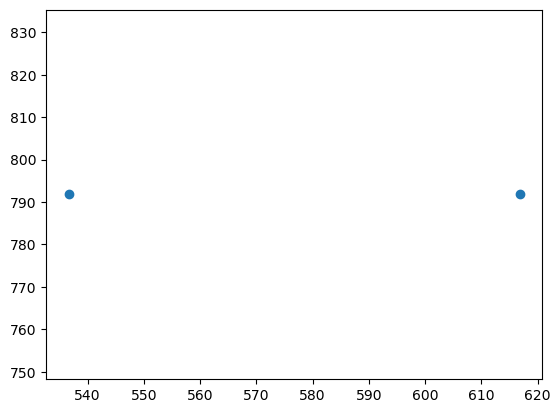

In [16]:
plt.scatter(x = np.array([616.85125643, 536.67686951]), y = np.array([791.7845897, 791.7845897]))

In [12]:
root = "C:/Users/Asentaja/Git/MicrorheologyProto/resource/gradB.csv"
past = 0
df = load_csv(root)
field = np.stack([df["r"].values,df["z"].values], axis = 1)

fieldArray =  np.asarray(field)
dBzVal = df["dBz"].values
dBrVal = df["dBr"].values

data = np.array([616.85125643,791.78458977,536.67686951,c])
x = data[0]
y = data[1]

x = emaFilter.filterNow(x)
y = emaFilter.filterNow(y)
place = np.stack([x,y])
idx = closestValue(place)
cB  = np.sqrt((dBzVal[idx])**2 + (dBzVal[idx])**2)

error = cB-past
#self.past = cB
#emitData(error)

In [141]:
import _pickle as cPickle
import scipy

from scipy.optimize import curve_fit

In [149]:
#path_calib = "./test/calib.npy"
path_driver = "./test/driver.npy"
path_frame = "./test/FrameInfo_4800.npy"
path_track = "./test/trackingData.pickle"

#file_calib = np.load(path_calib)
file_driver = np.load(path_driver)
file_frame = np.load(path_frame)

with open(path_track, "rb") as input_file:
    file_track = cPickle.load(input_file)

def kelvin(t,tau,D):
    return D*(1-np.exp(-t/tau))

def maxwell(t, D, tau):
    return D*(1+t/tau)

def maxwell_rel(t, E, tau ):
    return E*np.exp(-t/tau) 

In [150]:
df_current = pd.DataFrame(file_driver.T, columns= ["time", "target", "current", "B", "offset"])
df_track = pd.DataFrame.from_dict(file_track)

df_track["dx"] = scipy.ndimage.gaussian_filter(df_track["x"],5)
df_track["dy"] = scipy.ndimage.gaussian_filter(df_track["y"],5)

df_track["distance"] =df_track["dx"] + df_track["dy"]
df_track["distance"] = df_track["distance"].values.max()- df_track["distance"] 

df_track["time"] = df_track["t"]*1/40

Kelvin-Voigt:
 D:  0.9614515143057517 
tau:  2.358000522314679
Maxwell relaxation:
 E:  25.50004625894535 
tau:  0.9850670537921418


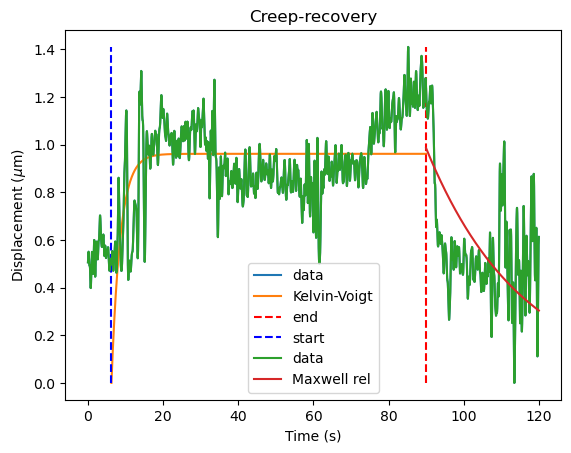

In [198]:
rel = int(100/40)
end_creep = int(df_track["t"].max()*0.75)
start_creep = int(10000/100*5/rel)

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat = np.arange(df_track["time"][start_creep:end_creep].min(),df_track["time"][start_creep:end_creep].max(), 0.001)

p, p_ = curve_fit(kelvin, df_track["time"][start_creep:end_creep]-df_track["time"][start_creep:end_creep].values[0], df_track["distance"][start_creep:end_creep], method = "dogbox")
plt.plot(t_hat, kelvin(t_hat-t_hat[0],*p), label = "Kelvin-Voigt")

print("Kelvin-Voigt:\n D: ", p[1], "\ntau: ", p[0] )

#p, p_ = curve_fit(maxwell, df_track["time"][start_creep:end_creep], df_track["distance"][start_creep:end_creep], method = "dogbox")
#plt.plot(t_hat, maxwell(t_hat,*p), label = "Maxwell")

#print("Maxwell:\n D: ", p_[1], "\ntau: ", p_[0] )

plt.title("Creep-recovery")
plt.xlabel("Time (s)")
plt.ylabel(r"Displacement ($\mu$m)")

plt.vlines(df_track["time"].max()*0.75, 0, df_track["distance"].max(), linestyles ="dashed", colors ="r", label = "end")
plt.vlines(df_track["time"][start_creep], 0, df_track["distance"].max(), linestyles ="dashed", colors ="b", label = "start")

start_rel = end_creep

rel_x = df_track["distance"][start_rel:].values

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat_rel = np.arange(df_track["time"][start_rel:].min(),df_track["time"][start_rel:].max(), 0.001)
#t_hat_rel -= t_hat_rel[0]

p, p_ = curve_fit(maxwell_rel, df_track["time"][start_rel:] - df_track["time"][start_rel:].values[0], df_track["distance"][start_rel:], bounds=([rel_x[0]*0.8,0], [rel_x[0]*1.2, 1e3]), maxfev = 10000)
plt.plot(t_hat_rel, maxwell_rel(t_hat_rel-t_hat_rel[0],*p), label = "Maxwell rel")
print("Maxwell relaxation:\n E: ", p[1], "\ntau: ", p[0] )

plt.legend()
plt.show()

#plt.plot(df_current["offset"])



In [22]:
import datetime
print(datetime.datetime.now().date)

<built-in method date of datetime.datetime object at 0x0000014AA1CC5DB0>


Maxwell relaxation:
 D:  [-1.85831945  6.96092928] 
tau:  [ 0.49941154 -1.85831945]


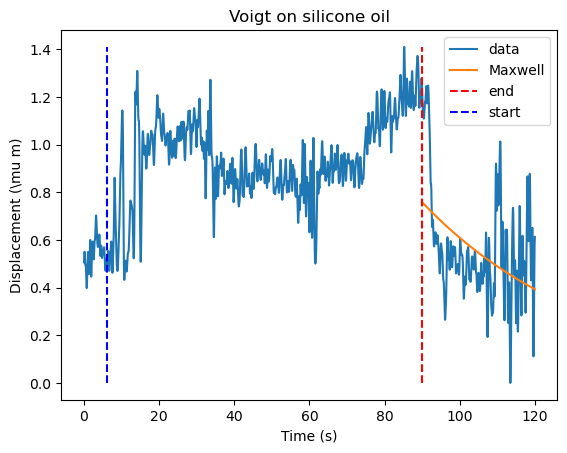

In [172]:
start_rel = end_creep

plt.plot(df_track["time"], df_track["distance"], label = "data")
t_hat_rel = np.arange(df_track["time"][start_rel:].min(),df_track["time"][start_rel:].max(), 0.001)

p, p_ = curve_fit(maxwell_rel, df_track["time"][start_rel:], df_track["distance"][start_rel:], bounds=([0,0], [1e3, 1e3]), maxfev = 10000)
plt.plot(t_hat_rel, maxwell_rel(t_hat_rel,*p), label = "Maxwell")

print("Maxwell relaxation:\n D: ", p_[1], "\ntau: ", p_[0] )

plt.title("Voigt on silicone oil")
plt.xlabel("Time (s)")
plt.ylabel("Displacement (\mu m)")

plt.vlines(df_track["time"].max()*0.75, 0, df_track["distance"].max(), linestyles ="dashed", colors ="r", label = "end")
plt.vlines(df_track["time"][start_creep], 0, df_track["distance"].max(), linestyles ="dashed", colors ="b", label = "start")

plt.legend()
plt.show()

#plt.plot(df_current["offset"])



In [130]:
import scipy

In [161]:
file =  "C:/Users/Asentaja/Data/OneCoil/One_coil.csv"

df = pd.read_csv(file, sep = ",", skiprows= [0], names = ["x", "y", "By", "Bx"])
#drop not needed
df.drop(df[df["y"].values < (3.5-0.9)*1e-3].index, inplace = True)
df.drop(df[df["x"].values > 0.9*1e-3].index, inplace = True)

df["y"] -= max(df["y"].values)
df["y"] = np.abs(df["y"])

df["Bx"] = scipy.ndimage.gaussian_filter1d(df["Bx"].values,5)
df["By"] = scipy.ndimage.gaussian_filter1d(df["By"].values,5)

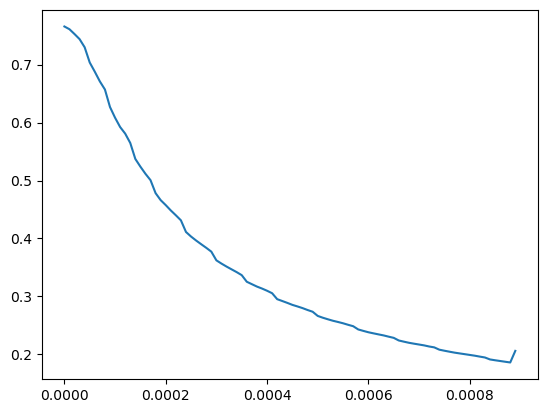

In [162]:
mask = df["x"] == 0
plt.plot(df["y"][mask],df["By"][mask])

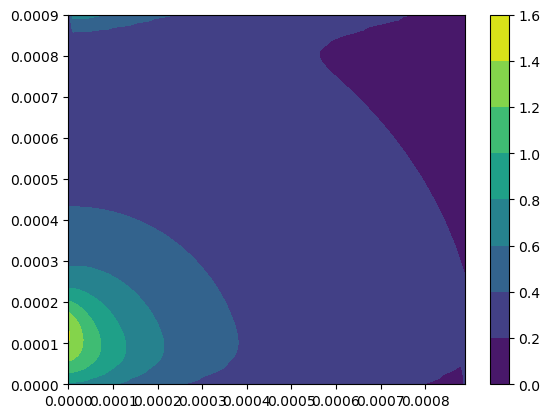

In [163]:
xx, yy = np.meshgrid(df["x"].unique(), df["y"].unique())
data = np.array(df["By"].values).reshape(len(df["y"].unique()),len(df["x"].unique()))
plt.contourf(yy,xx, data)
plt.colorbar()


In [155]:
3.5/(10*0.3*3.3)*2500

883.838383838384